# P1: Image segmentation

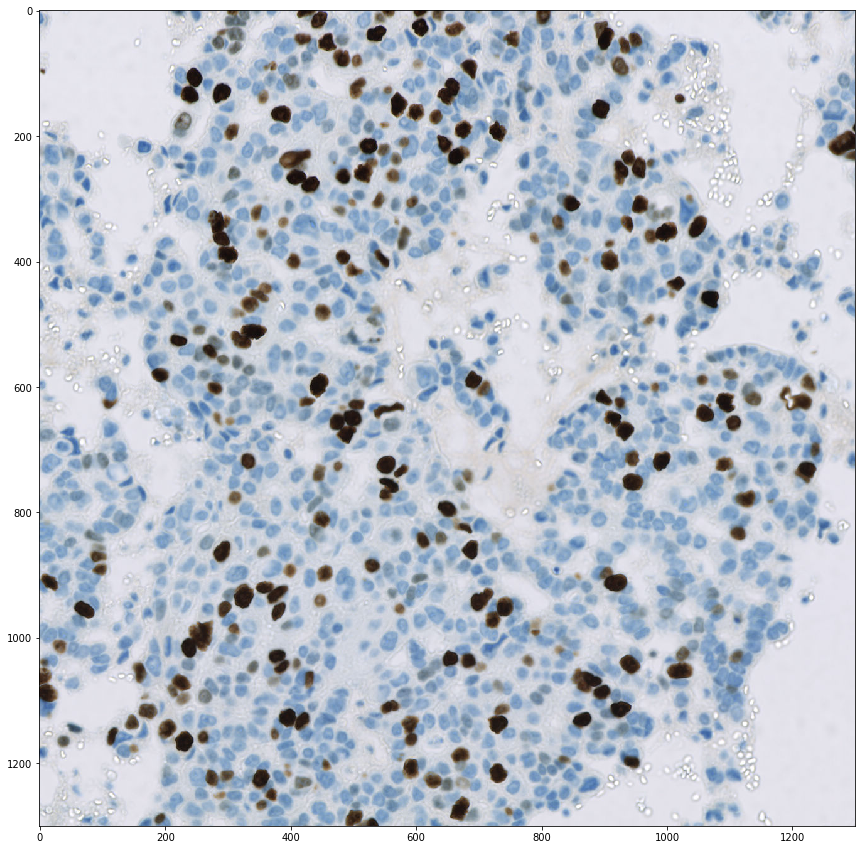

In [9]:
import numpy as np 
import cv2
import openslide
from matplotlib import pyplot as plt

#reading a small region
openslide_tissue=openslide.OpenSlide("F:\BSU_FAMCS\BMI\CourseProject\HistologyImageExamples\OS-2(Ki-67).ndpi")
tissue_region=openslide_tissue.read_region((58200,41000),1,(1300,1300))
plt.figure(figsize=[15,15])
plt.imshow(tissue_region)
plt.show()

#saving this region
tissue_region.save("tissue_region.png","PNG")

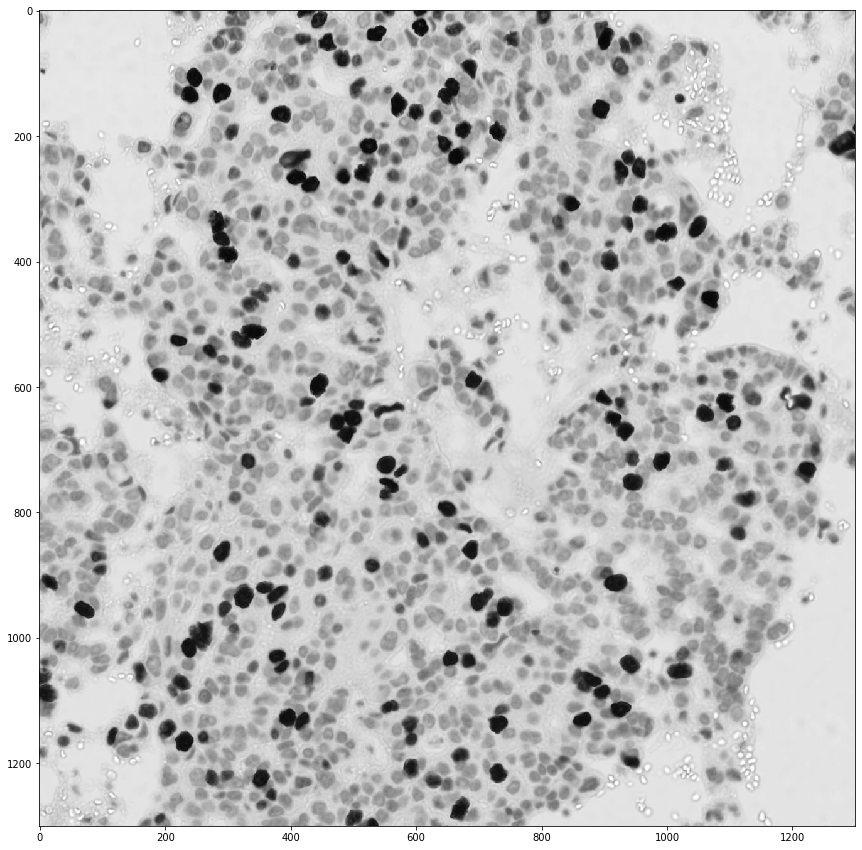

In [10]:
#loading tissue
tissue=cv2.imread("tissue_region.png")
tissue_hsv=cv2.cvtColor(tissue,cv2.COLOR_BGR2HSV)
tissue_gray=cv2.cvtColor(tissue,cv2.COLOR_BGR2GRAY)
plt.figure(figsize=[15,15])
plt.imshow(tissue_gray,cmap='gray')
plt.show()

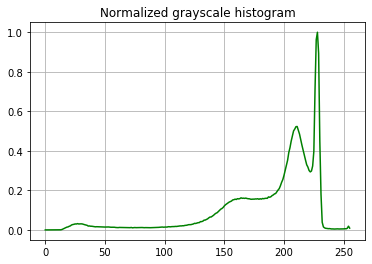

In [107]:
#Calculating histogram
hist=cv2.calcHist([tissue_gray],[0],None,[256],[0,256])
#plt.figure(figsize=[15,15])

#normalizing histogram
max_value=0
for x in hist:
    if x>max_value:
        max_value=x

hist_normalized=hist/max_value

plt.grid(axis="both")
plt.title("Normalized grayscale histogram")
plt.plot(hist_normalized,color='g')
plt.show()

In [145]:
#SDD
#Slope difference distribution
N=10
a1=[]
a2=[]
s=[]
B=np.zeros((N,2))
Y=np.zeros((N))

def inverse_matrix(A):
    determinant=np.linalg.det(A)
    temp=A[0][0]
    A[0][0]=A[1][1]
    A[1][1]=temp
    A[0][1]=-A[0][1]
    A[1][0]=-A[1][0]
    if determinant != 0:
        A=A/determinant
    return A

    
for i in range(N,256-N):
    #Left
    counter=0
    for j in range(i-N,i):
        B[counter][0]=j
        B[counter][1]=1
        Y[counter]=hist_normalized[j]
        counter+=1
        a_b=inverse_matrix(np.dot(B.T,B))
        a_b=np.dot(a_b,B.T)
        a_b=np.dot(a_b,Y)
        a1.append(a_b[0])
    #Right
    counter=0
    for j in range(i,i+N):
        B[counter][0]=j
        B[counter][1]=1
        Y[counter]=hist_normalized[j]
        counter+=1
        a_b=inverse_matrix(np.dot(B.T,B))
        a_b=np.dot(a_b,B.T)
        a_b=np.dot(a_b,Y)
        a2.append(a_b[0])
    s.append(a2[-1]-a1[-1])    
    

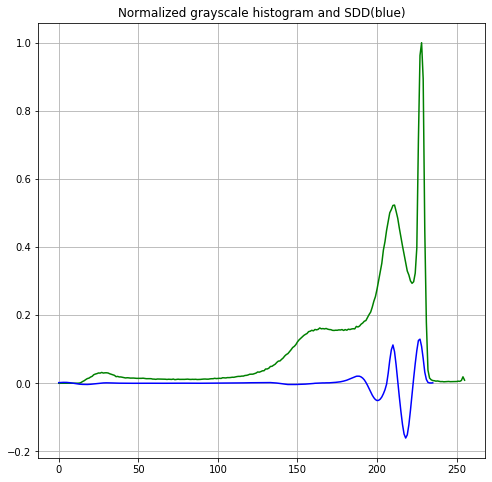

In [146]:
#trying to plot SDD
plt.figure(figsize=[8,8])
plt.grid(axis="both")
plt.title("Normalized grayscale histogram and SDD(blue)")
plt.plot(hist_normalized,color='g')
plt.plot(s,color='b')
plt.show()

In [169]:
#trying to find peaks positions(make derivative equal to 0)
#And find T1 as a min between P1 and P2,where P1 ans P2 are the biggest peaks
import scipy.signal

peaks, _=scipy.signal.find_peaks(s)

P1value=0
P2value=0
P1=0
P2=0

for index,x in enumerate(peaks):
    if s[x]>P1value:
        P2=P1
        P1=x
        P1value=s[x]
print("P1:{}, P2:{}".format(P1,P2)) 

T1=-1
min_value=P1value
for i in range(min(P1,P2),max(P1,P2)):
    if s[i]<min_value:
        min_value=s[i]
        T1=i
T1

P1:227, P2:210


218

######  T1 counted for this image is 218

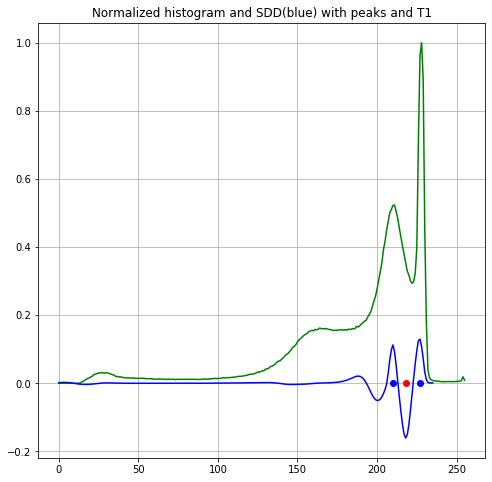

In [170]:
plt.figure(figsize=[8,8])
plt.grid(axis="both")
plt.title("Normalized histogram and SDD(blue) with peaks and T1")
plt.plot(hist_normalized,color='g')
plt.plot(s,color='b')
plt.plot(P1,0,"bo")
plt.plot(P2,0,"bo")
plt.plot(T1,0,"ro")
plt.show()

# Binarization

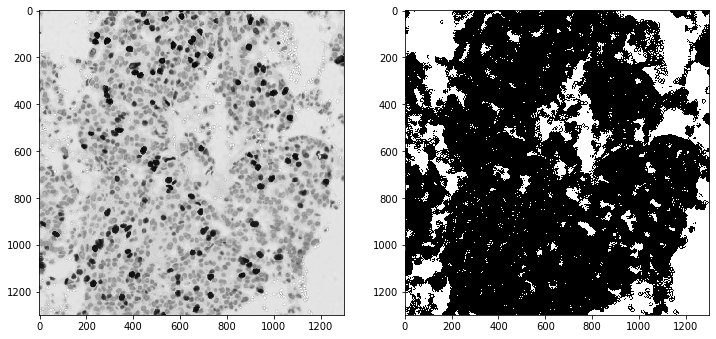

In [187]:
tissue_gray_bin=tissue_gray>T1
plt.figure(figsize=[12,12])
plt.subplot(1,2,1), plt.imshow(tissue_gray,cmap="gray")
plt.subplot(1,2,2), plt.imshow(tissue_gray_bin,cmap="gray")
plt.show()

### Making gifs

In [265]:
import imageio
import cv2 

with imageio.get_writer("myGif.gif", mode="I") as writer:
    for threshold in range(10,210,5):
        ret, thresh1=cv2.threshold(tissue_gray,threshold,255,cv2.THRESH_BINARY_INV)
        cv2.imwrite("ThresholdFrames/{}.png".format(str(threshold)),thresh1)
        img=imageio.imread("ThresholdFrames/{}.png".format(threshold))
        
        writer.append_data(img)
        writer.append_data(img)
        writer.append_data(img)
        

### Blurring

In [235]:
import cv2

#working with tissue_gray image
#cv2 AVERAGE blurring (5,5)
average_blurred=cv2.blur(tissue_gray,(7,7))
cv2.imwrite("Blurred/averageBlurring.png",average_blurred)

True

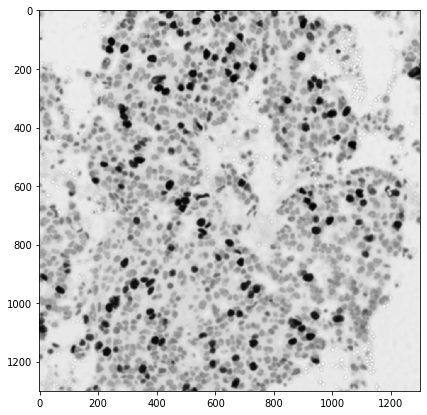

In [236]:
plt.figure(figsize=(7,7))
plt.imshow(average_blurred,cmap="gray")
plt.show()

In [240]:
#GAUSSIAN BLUR
gaussian_blurred=cv2.GaussianBlur(tissue_gray,(5,5),0)
cv2.imwrite("Blurred/GaussianBlurring.png",gaussian_blurred)

True

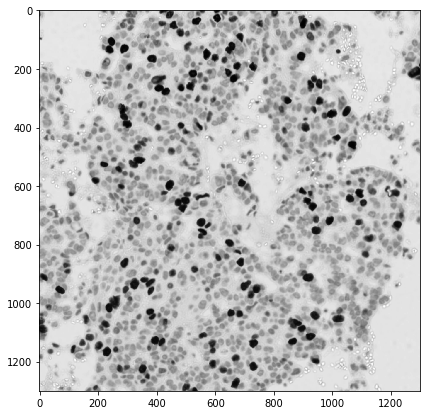

In [241]:
plt.figure(figsize=(7,7))
plt.imshow(gaussian_blurred,cmap="gray")
plt.show()

In [258]:
#BILATERAL FILTER blurring
bilateral_blurred=cv2.bilateralFilter(tissue_gray,19,75,75)
#cv2.imwrite("Blurred/bilateralBlurring.png",bilateral_blurred)

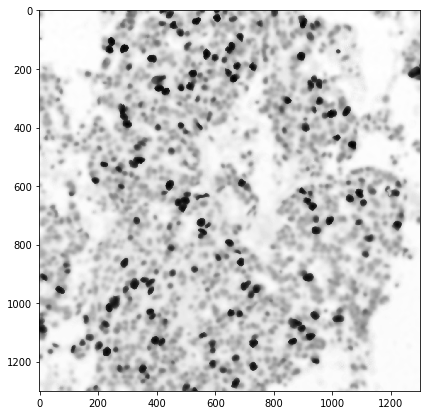

In [259]:
plt.figure(figsize=(7,7))
plt.imshow(bilateral_blurred,cmap="gray")
plt.show()

### Distance transform

  0%|          | 0/42 [00:00<?, ?it/s]

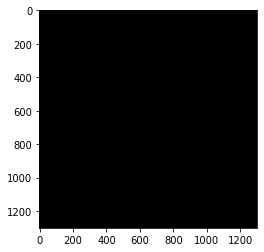

  2%|▏         | 1/42 [00:00<00:14,  2.79it/s]

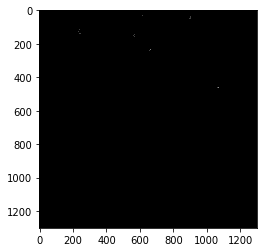

  5%|▍         | 2/42 [00:00<00:14,  2.84it/s]

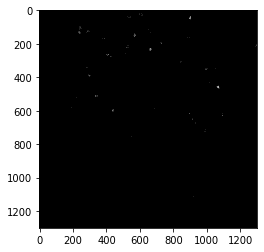

  7%|▋         | 3/42 [00:01<00:13,  2.84it/s]

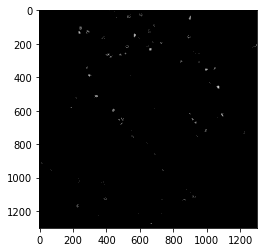

 10%|▉         | 4/42 [00:01<00:14,  2.70it/s]

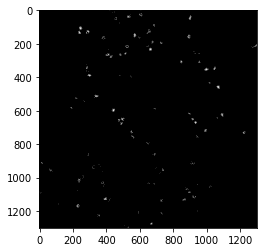

 12%|█▏        | 5/42 [00:02<00:19,  1.87it/s]

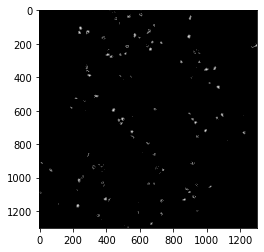

 14%|█▍        | 6/42 [00:02<00:17,  2.02it/s]

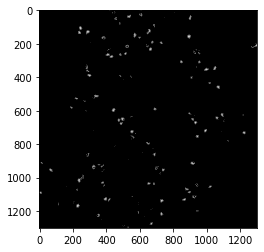

 17%|█▋        | 7/42 [00:03<00:17,  2.05it/s]

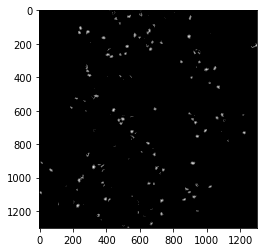

 19%|█▉        | 8/42 [00:03<00:17,  1.96it/s]

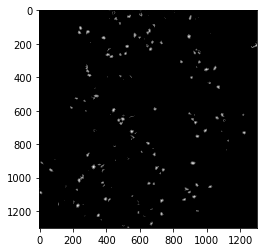

 21%|██▏       | 9/42 [00:04<00:15,  2.13it/s]

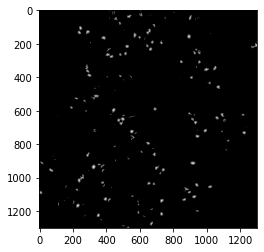

 24%|██▍       | 10/42 [00:04<00:14,  2.19it/s]

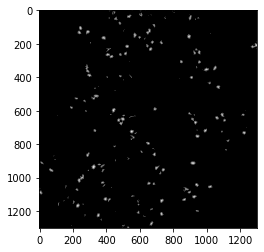

 26%|██▌       | 11/42 [00:04<00:12,  2.41it/s]

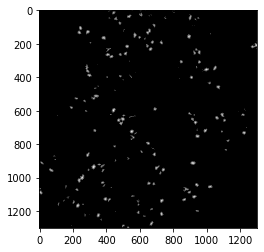

 29%|██▊       | 12/42 [00:05<00:12,  2.46it/s]

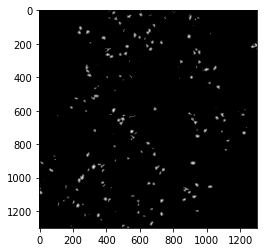

 31%|███       | 13/42 [00:05<00:11,  2.42it/s]

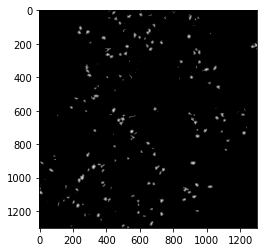

 33%|███▎      | 14/42 [00:06<00:10,  2.58it/s]

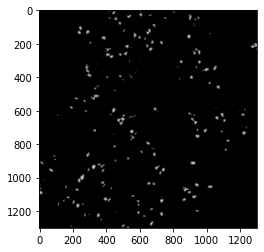

 36%|███▌      | 15/42 [00:06<00:10,  2.69it/s]

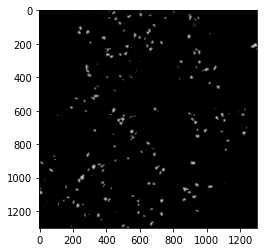

 38%|███▊      | 16/42 [00:06<00:10,  2.58it/s]

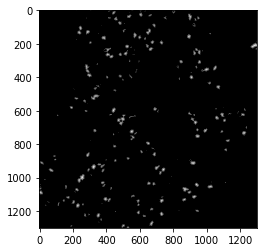

 40%|████      | 17/42 [00:07<00:10,  2.49it/s]

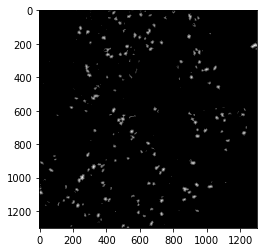

 43%|████▎     | 18/42 [00:07<00:09,  2.45it/s]

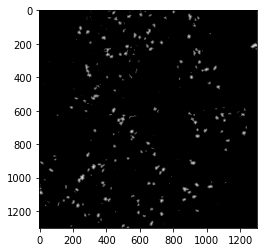

 45%|████▌     | 19/42 [00:08<00:09,  2.49it/s]

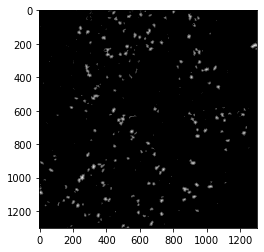

 48%|████▊     | 20/42 [00:08<00:08,  2.50it/s]

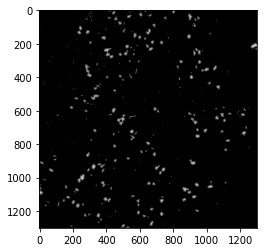

 50%|█████     | 21/42 [00:08<00:08,  2.48it/s]

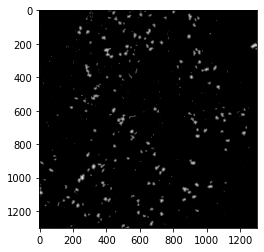

 52%|█████▏    | 22/42 [00:09<00:08,  2.43it/s]

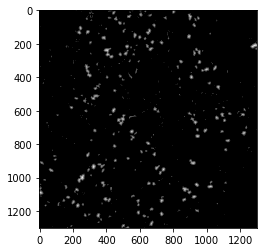

 55%|█████▍    | 23/42 [00:09<00:07,  2.55it/s]

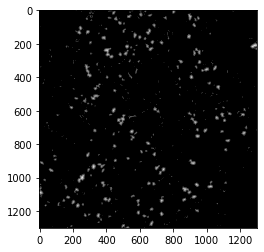

 57%|█████▋    | 24/42 [00:10<00:07,  2.50it/s]

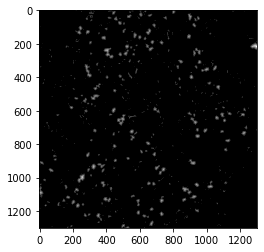

 60%|█████▉    | 25/42 [00:10<00:06,  2.62it/s]

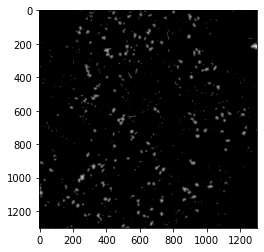

 62%|██████▏   | 26/42 [00:10<00:06,  2.55it/s]

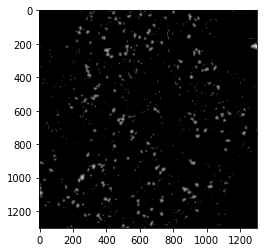

 64%|██████▍   | 27/42 [00:11<00:05,  2.61it/s]

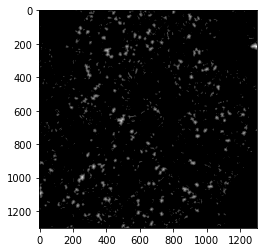

 67%|██████▋   | 28/42 [00:11<00:05,  2.59it/s]

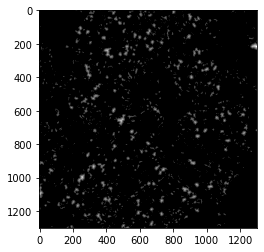

 69%|██████▉   | 29/42 [00:12<00:05,  2.51it/s]

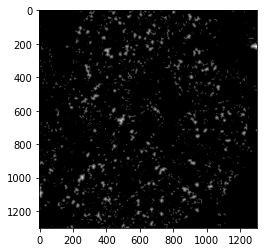

 71%|███████▏  | 30/42 [00:12<00:04,  2.52it/s]

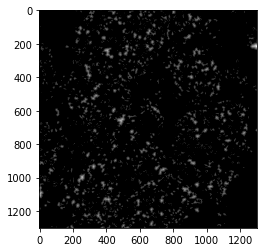

 74%|███████▍  | 31/42 [00:12<00:04,  2.34it/s]

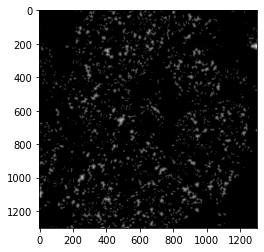

 76%|███████▌  | 32/42 [00:13<00:04,  2.30it/s]

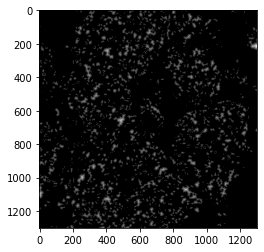

 79%|███████▊  | 33/42 [00:13<00:04,  2.08it/s]

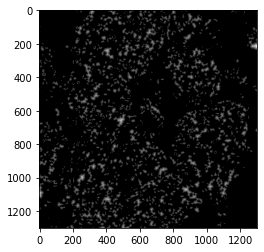

 81%|████████  | 34/42 [00:14<00:03,  2.01it/s]

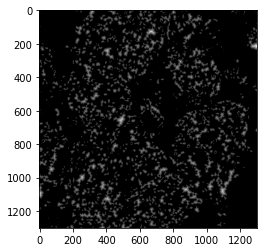

 83%|████████▎ | 35/42 [00:14<00:03,  2.09it/s]

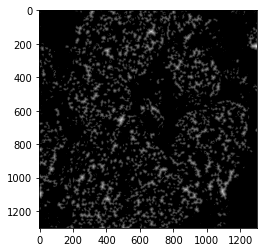

 86%|████████▌ | 36/42 [00:15<00:02,  2.05it/s]

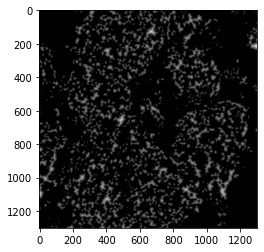

 88%|████████▊ | 37/42 [00:15<00:02,  2.05it/s]

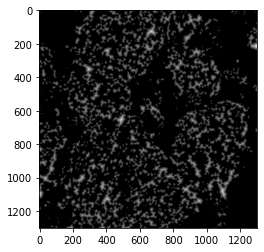

 90%|█████████ | 38/42 [00:16<00:01,  2.11it/s]

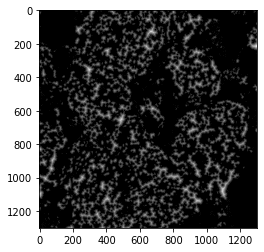

 93%|█████████▎| 39/42 [00:16<00:01,  2.15it/s]

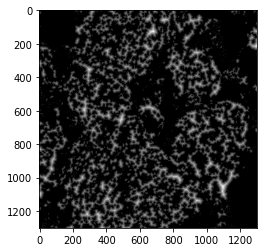

 95%|█████████▌| 40/42 [00:17<00:00,  2.20it/s]

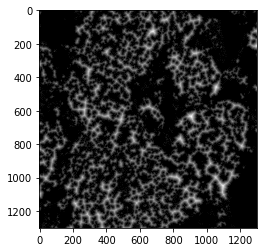

 98%|█████████▊| 41/42 [00:17<00:00,  2.07it/s]

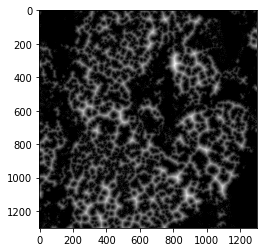

100%|██████████| 42/42 [00:18<00:00,  2.30it/s]


In [281]:
from tqdm import tqdm
start_threshold=10
end_threshold=220
step=5

for threshold in tqdm(range(start_threshold,end_threshold,step)):
    #Thresholding
    ret,threshed_img=cv2.threshold(tissue_gray,threshold,255,cv2.THRESH_BINARY_INV)
    #Distance_transform
    dist_transformed=cv2.distanceTransform(threshed_img,cv2.DIST_L2,5)
    plt.imshow(dist_transformed,cmap="gray")
    plt.show()
    

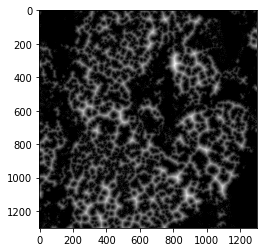

In [278]:
plt.imshow(dist_transformed,cmap="gray")
plt.show()

# P2: Segmenting and counting cells

###### Parsing to HSV & mask creating

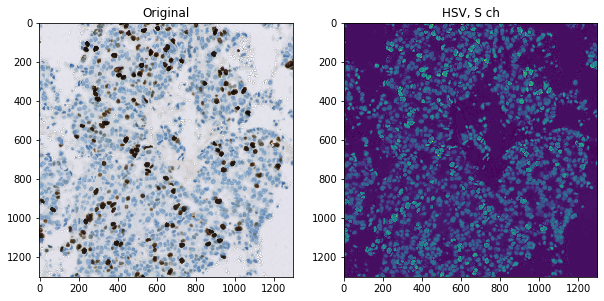

In [5]:
tissue_hsv=cv2.cvtColor(tissue,cv2.COLOR_BGR2HSV)

plt.figure(figsize=(10,10))
plt.subplot(1,2,1), plt.title("Original"), plt.imshow(tissue_region)
plt.subplot(1,2,2), plt.title("HSV, S ch"), plt.imshow(tissue_hsv[:,:,1])
plt.show()

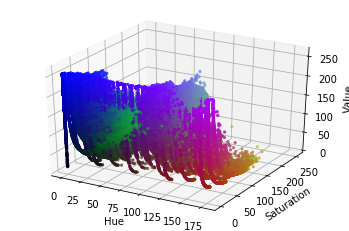

In [321]:
# 3D representation 
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib import colors
tissue_hsv_copy=np.copy(tissue_hsv)

pixel_colors = tissue_hsv_copy.reshape((np.shape(tissue_hsv_copy)[0]*np.shape(tissue_hsv_copy)[1], 3))
norm = colors.Normalize(vmin=-1.,vmax=1.)
norm.autoscale(pixel_colors)
pixel_colors = norm(pixel_colors).tolist()

h, s, v = cv2.split(tissue_hsv_copy)
fig = plt.figure()
axis = fig.add_subplot(1, 1, 1, projection="3d")

axis.scatter(h.flatten(), s.flatten(), v.flatten(), facecolors=pixel_colors, marker=".")
axis.set_xlabel("Hue")
axis.set_ylabel("Saturation")
axis.set_zlabel("Value")
plt.show()

In [144]:
#MASK by brown threshold for saturation channel
temp_thresh=90

ret, mask_single=cv2.threshold(tissue_hsv[:,:,1],temp_thresh,255,cv2.THRESH_BINARY)

lower_brown=np.array([10, 100, 20])
upper_brown=np.array([20, 255, 200])
#Mask by brown threshold interval for all HSV
mask=cv2.inRange(tissue_hsv,lower_brown,upper_brown)

#blurred_saturation=cv2.bilateralFilter(tissue_hsv[:,:,1],20,75,75)
#Blurred mask for saturation channel 
#ret, mask_blurred=cv2.threshold(blurred_saturation,temp_thresh,255,cv2.THRESH_BINARY)

#saving masks
cv2.imwrite("mask.png",mask)
cv2.imwrite("mask_single.png",mask_single)

True

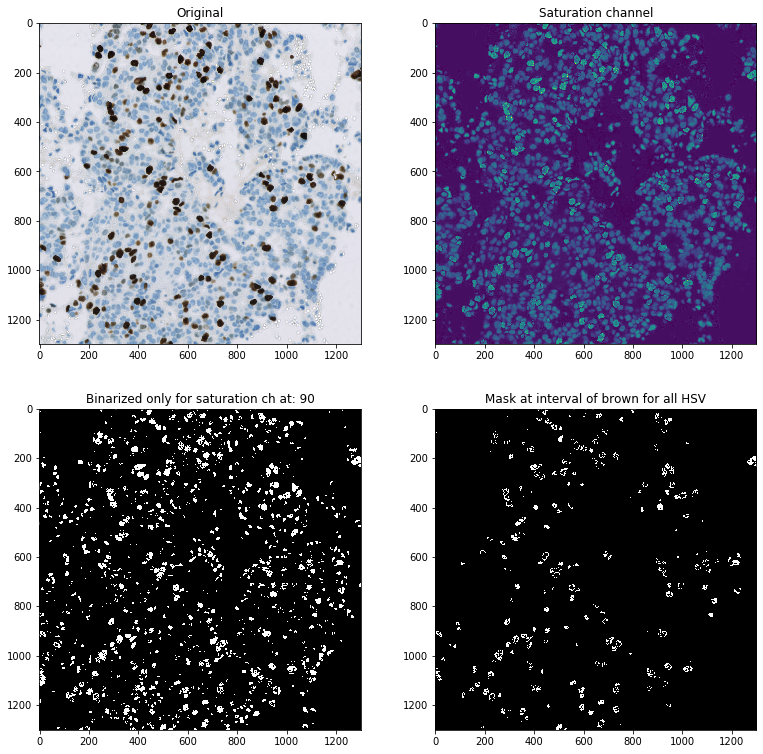

In [148]:
#Output
plt.figure(figsize=(13,13))
plt.subplot(2,2,1), plt.title("Original"), plt.imshow(tissue_region)
plt.subplot(2,2,2), plt.title("Saturation channel"), plt.imshow(tissue_hsv[:,:,1])
plt.subplot(2,2,3), plt.title("Binarized only for saturation ch at: {}".format(temp_thresh)), plt.imshow(mask_single,cmap="gray")
plt.subplot(2,2,4), plt.title("Mask at interval of brown for all HSV"), plt.imshow(mask,cmap="gray")

plt.show()

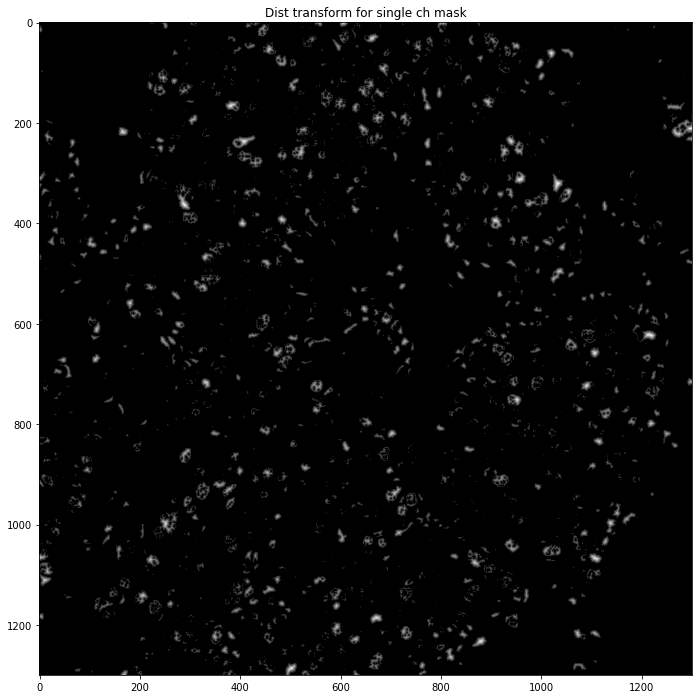

In [157]:
#Disance transform to masks
dt_mask_single=cv2.distanceTransform(mask_single,cv2.DIST_L2,0)
dt_mask=cv2.distanceTransform(mask,cv2.DIST_L2,5)

coefficient=40
#In order not to save just black images
dt_mask_single_f=dt_mask_single*coefficient
dt_mask_f=dt_mask*coefficient

cv2.imwrite("dt_mask_single.png",dt_mask_single_f)
cv2.imwrite("dt_mask.png",dt_mask_f)

plt.figure(figsize=(12,12))
plt.title("Dist transform for single ch mask")
plt.imshow(dt_mask_single,cmap="gray")
plt.show()


###### Trying to find contours in distantly transformed mask

In [150]:
#first one is source image, second is contour retrieval mode, third is contour approximation method
dt_mask_single_typed=cv2.convertScaleAbs(dt_mask_single)
contours,hierarchy=cv2.findContours(dt_mask_single_typed,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)


In [31]:
dt_mask_single.dtype


dt_mask_single_typed

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [51]:
counter=0
for contour in contours:
    counter+=1
    print(counter)
    for dot in contour:
        for x,y in dot:
            print("x: {}, y: {}".format(x,y))

1
x: 541, y: 1300
2
x: 536, y: 1297
x: 536, y: 1299
x: 537, y: 1300
x: 539, y: 1300
x: 538, y: 1299
x: 538, y: 1298
x: 537, y: 1298
3
x: 766, y: 1294
x: 765, y: 1295
x: 768, y: 1295
x: 768, y: 1294
4
x: 629, y: 1293
x: 628, y: 1294
x: 628, y: 1297
x: 629, y: 1298
x: 629, y: 1300
x: 635, y: 1300
x: 632, y: 1297
x: 632, y: 1296
x: 631, y: 1295
x: 631, y: 1294
x: 630, y: 1293
5
x: 172, y: 1292
x: 169, y: 1295
x: 168, y: 1295
x: 166, y: 1297
x: 166, y: 1298
x: 165, y: 1299
x: 165, y: 1300
x: 174, y: 1300
x: 175, y: 1299
x: 175, y: 1296
x: 176, y: 1295
x: 176, y: 1293
x: 175, y: 1292
x: 174, y: 1292
x: 173, y: 1293
6
x: 529, y: 1291
x: 527, y: 1293
x: 525, y: 1293
x: 526, y: 1294
x: 525, y: 1295
x: 525, y: 1296
x: 524, y: 1297
x: 524, y: 1298
x: 525, y: 1299
x: 525, y: 1300
x: 527, y: 1300
x: 527, y: 1299
x: 528, y: 1298
x: 528, y: 1295
x: 529, y: 1294
x: 528, y: 1293
x: 529, y: 1292
x: 532, y: 1292
x: 533, y: 1293
x: 532, y: 1294
x: 532, y: 1295
x: 533, y: 1296
x: 533, y: 1299
x: 533, y: 1

x: 937, y: 1199
x: 938, y: 1198
x: 938, y: 1196
91
x: 597, y: 1196
x: 596, y: 1197
x: 591, y: 1197
x: 590, y: 1198
x: 590, y: 1199
x: 591, y: 1200
x: 590, y: 1201
x: 589, y: 1201
x: 588, y: 1202
x: 588, y: 1203
x: 587, y: 1204
x: 588, y: 1205
x: 587, y: 1206
x: 586, y: 1206
x: 584, y: 1204
x: 583, y: 1204
x: 583, y: 1209
x: 585, y: 1211
x: 585, y: 1212
x: 586, y: 1213
x: 586, y: 1214
x: 588, y: 1216
x: 588, y: 1220
x: 588, y: 1219
x: 589, y: 1218
x: 590, y: 1218
x: 591, y: 1219
x: 593, y: 1219
x: 594, y: 1220
x: 599, y: 1220
x: 599, y: 1219
x: 602, y: 1216
x: 602, y: 1213
x: 601, y: 1212
x: 601, y: 1210
x: 600, y: 1209
x: 600, y: 1206
x: 599, y: 1205
x: 600, y: 1204
x: 601, y: 1204
x: 601, y: 1202
x: 600, y: 1201
x: 600, y: 1200
x: 601, y: 1199
x: 601, y: 1197
x: 599, y: 1197
x: 598, y: 1196
92
x: 596, y: 1216
x: 597, y: 1215
x: 598, y: 1216
x: 597, y: 1217
93
x: 588, y: 1215
x: 589, y: 1214
x: 590, y: 1215
x: 590, y: 1217
x: 589, y: 1218
x: 588, y: 1217
94
x: 596, y: 1208
x: 597, y: 1

x: 421, y: 1134
x: 422, y: 1134
x: 422, y: 1133
x: 421, y: 1133
x: 420, y: 1132
x: 421, y: 1131
x: 422, y: 1131
x: 423, y: 1130
x: 424, y: 1131
x: 424, y: 1132
x: 427, y: 1132
x: 428, y: 1133
x: 427, y: 1134
x: 426, y: 1134
x: 425, y: 1135
x: 425, y: 1136
x: 424, y: 1137
x: 423, y: 1137
x: 422, y: 1138
x: 424, y: 1138
x: 426, y: 1136
x: 428, y: 1136
x: 428, y: 1133
x: 427, y: 1132
x: 427, y: 1131
x: 428, y: 1130
x: 428, y: 1129
x: 426, y: 1129
x: 424, y: 1127
x: 424, y: 1126
x: 423, y: 1125
x: 424, y: 1124
x: 425, y: 1124
x: 424, y: 1124
x: 423, y: 1123
x: 423, y: 1122
217
x: 1025, y: 1121
x: 1025, y: 1122
x: 1024, y: 1123
x: 1024, y: 1124
x: 1026, y: 1124
x: 1026, y: 1121
218
x: 178, y: 1120
x: 178, y: 1122
x: 177, y: 1123
x: 177, y: 1124
x: 176, y: 1125
x: 174, y: 1125
x: 174, y: 1127
x: 175, y: 1127
x: 176, y: 1128
x: 177, y: 1128
x: 178, y: 1127
x: 178, y: 1126
x: 177, y: 1125
x: 179, y: 1123
x: 180, y: 1123
x: 181, y: 1124
x: 181, y: 1123
x: 180, y: 1122
x: 180, y: 1121
x: 179, y:

x: 680, y: 1037
324
x: 381, y: 1037
x: 384, y: 1037
325
x: 371, y: 1037
x: 373, y: 1037
326
x: 1004, y: 1036
327
x: 949, y: 1036
328
x: 693, y: 1036
329
x: 651, y: 1035
x: 651, y: 1036
x: 652, y: 1037
x: 652, y: 1038
x: 651, y: 1039
x: 651, y: 1040
x: 652, y: 1041
x: 652, y: 1044
x: 652, y: 1036
330
x: 684, y: 1034
331
x: 649, y: 1034
x: 648, y: 1035
x: 649, y: 1036
332
x: 678, y: 1031
x: 678, y: 1032
x: 677, y: 1033
x: 676, y: 1032
x: 676, y: 1036
x: 675, y: 1037
x: 675, y: 1039
x: 676, y: 1040
x: 676, y: 1042
x: 676, y: 1034
x: 677, y: 1033
x: 678, y: 1034
x: 678, y: 1035
x: 679, y: 1035
x: 679, y: 1031
333
x: 649, y: 1031
334
x: 389, y: 1031
x: 390, y: 1031
335
x: 683, y: 1030
x: 684, y: 1031
x: 684, y: 1032
x: 684, y: 1031
336
x: 240, y: 1030
x: 241, y: 1030
337
x: 938, y: 1029
x: 935, y: 1032
x: 934, y: 1032
x: 932, y: 1034
x: 931, y: 1034
x: 928, y: 1037
x: 928, y: 1038
x: 929, y: 1039
x: 929, y: 1040
x: 928, y: 1041
x: 928, y: 1042
x: 929, y: 1043
x: 929, y: 1044
x: 931, y: 1046

x: 8, y: 921
453
x: 391, y: 920
x: 390, y: 921
x: 389, y: 921
x: 389, y: 923
x: 388, y: 924
x: 380, y: 924
x: 379, y: 925
x: 376, y: 925
x: 376, y: 927
x: 375, y: 928
x: 373, y: 928
x: 373, y: 930
x: 372, y: 931
x: 369, y: 931
x: 368, y: 932
x: 367, y: 932
x: 371, y: 932
x: 372, y: 933
x: 372, y: 934
x: 371, y: 935
x: 371, y: 936
x: 372, y: 936
x: 373, y: 935
x: 375, y: 935
x: 376, y: 934
x: 375, y: 933
x: 376, y: 932
x: 382, y: 932
x: 383, y: 933
x: 382, y: 934
x: 382, y: 935
x: 384, y: 935
x: 386, y: 933
x: 385, y: 932
x: 385, y: 928
x: 384, y: 927
x: 385, y: 926
x: 385, y: 925
x: 386, y: 924
x: 388, y: 924
x: 389, y: 923
x: 390, y: 923
x: 391, y: 924
x: 391, y: 925
x: 389, y: 927
x: 389, y: 930
x: 389, y: 929
x: 393, y: 925
x: 392, y: 924
x: 394, y: 922
x: 393, y: 921
x: 392, y: 921
454
x: 373, y: 933
x: 374, y: 932
x: 375, y: 933
x: 374, y: 934
455
x: 383, y: 928
x: 384, y: 927
x: 385, y: 928
x: 385, y: 929
x: 384, y: 930
x: 383, y: 929
456
x: 348, y: 920
x: 348, y: 921
x: 347, y: 

x: 806, y: 812
x: 805, y: 811
x: 805, y: 810
x: 804, y: 809
x: 800, y: 809
x: 798, y: 807
x: 798, y: 805
538
x: 648, y: 805
x: 650, y: 805
x: 651, y: 806
x: 652, y: 805
x: 653, y: 806
x: 656, y: 806
x: 656, y: 805
x: 655, y: 805
x: 654, y: 806
x: 653, y: 806
x: 652, y: 805
539
x: 452, y: 805
x: 452, y: 808
x: 453, y: 809
x: 453, y: 814
x: 452, y: 815
x: 451, y: 814
x: 451, y: 813
x: 449, y: 811
x: 445, y: 811
x: 444, y: 810
x: 444, y: 807
x: 443, y: 808
x: 443, y: 810
x: 444, y: 811
x: 444, y: 812
x: 443, y: 813
x: 442, y: 813
x: 440, y: 815
x: 440, y: 816
x: 442, y: 816
x: 444, y: 818
x: 444, y: 819
x: 445, y: 819
x: 446, y: 820
x: 448, y: 820
x: 449, y: 819
x: 452, y: 819
x: 453, y: 820
x: 452, y: 821
x: 451, y: 821
x: 452, y: 822
x: 453, y: 822
x: 454, y: 823
x: 455, y: 823
x: 459, y: 819
x: 459, y: 818
x: 458, y: 817
x: 458, y: 816
x: 459, y: 815
x: 460, y: 815
x: 460, y: 813
x: 461, y: 812
x: 461, y: 811
x: 460, y: 810
x: 460, y: 808
x: 459, y: 809
x: 458, y: 809
x: 457, y: 808
x:

x: 984, y: 729
x: 985, y: 730
x: 985, y: 732
x: 986, y: 733
x: 990, y: 733
x: 988, y: 731
x: 989, y: 730
x: 989, y: 729
x: 988, y: 730
x: 987, y: 730
x: 986, y: 729
x: 986, y: 727
x: 985, y: 727
x: 984, y: 726
x: 985, y: 727
x: 984, y: 728
x: 983, y: 728
608
x: 329, y: 726
x: 329, y: 728
x: 330, y: 729
x: 331, y: 728
x: 331, y: 727
x: 330, y: 726
609
x: 1231, y: 725
x: 1231, y: 726
x: 1229, y: 728
x: 1229, y: 730
x: 1231, y: 730
x: 1232, y: 731
x: 1232, y: 732
x: 1231, y: 733
x: 1231, y: 735
x: 1230, y: 736
x: 1230, y: 742
x: 1229, y: 743
x: 1229, y: 744
x: 1231, y: 744
x: 1232, y: 743
x: 1232, y: 739
x: 1233, y: 738
x: 1233, y: 735
x: 1234, y: 734
x: 1235, y: 734
x: 1235, y: 729
x: 1232, y: 726
x: 1232, y: 725
610
x: 549, y: 723
x: 549, y: 724
x: 548, y: 725
x: 548, y: 726
x: 548, y: 725
x: 549, y: 724
x: 556, y: 724
x: 555, y: 723
611
x: 949, y: 719
x: 949, y: 720
612
x: 324, y: 718
x: 324, y: 721
613
x: 1089, y: 716
x: 1090, y: 716
x: 1091, y: 717
x: 1089, y: 719
x: 1088, y: 718
x: 

x: 561, y: 635
x: 558, y: 635
x: 556, y: 637
x: 554, y: 637
x: 553, y: 636
x: 554, y: 635
x: 553, y: 634
x: 551, y: 634
x: 550, y: 635
x: 549, y: 635
x: 548, y: 634
x: 546, y: 634
x: 545, y: 635
x: 544, y: 635
x: 542, y: 637
x: 541, y: 637
x: 539, y: 639
x: 536, y: 639
x: 536, y: 641
x: 537, y: 642
x: 536, y: 643
x: 536, y: 644
x: 537, y: 645
x: 537, y: 647
x: 538, y: 648
x: 540, y: 648
x: 540, y: 647
x: 541, y: 646
x: 543, y: 646
x: 543, y: 645
x: 544, y: 644
x: 544, y: 643
x: 547, y: 640
x: 549, y: 640
x: 550, y: 639
x: 552, y: 639
x: 553, y: 638
x: 556, y: 638
x: 557, y: 639
x: 559, y: 639
x: 560, y: 638
x: 566, y: 638
x: 567, y: 637
x: 572, y: 637
x: 573, y: 636
x: 576, y: 636
x: 577, y: 637
x: 580, y: 637
x: 580, y: 635
x: 578, y: 633
x: 578, y: 632
x: 577, y: 632
x: 576, y: 631
x: 575, y: 631
x: 574, y: 630
x: 573, y: 630
716
x: 556, y: 637
x: 557, y: 636
x: 560, y: 636
x: 561, y: 637
x: 560, y: 638
x: 557, y: 638
717
x: 571, y: 636
x: 572, y: 635
x: 573, y: 636
x: 572, y: 637
71

x: 449, y: 608
x: 448, y: 608
x: 448, y: 609
x: 447, y: 610
x: 446, y: 610
x: 444, y: 612
x: 443, y: 611
x: 443, y: 610
x: 441, y: 610
x: 440, y: 609
x: 439, y: 609
x: 438, y: 610
x: 437, y: 610
x: 436, y: 609
x: 436, y: 605
x: 436, y: 606
x: 435, y: 607
x: 434, y: 606
x: 434, y: 601
x: 433, y: 600
x: 433, y: 601
x: 434, y: 602
x: 434, y: 607
x: 435, y: 608
x: 435, y: 609
x: 436, y: 610
x: 436, y: 611
x: 438, y: 613
x: 439, y: 612
x: 441, y: 612
x: 442, y: 613
x: 441, y: 614
x: 441, y: 615
x: 443, y: 617
x: 444, y: 616
x: 446, y: 616
x: 448, y: 614
x: 448, y: 613
x: 449, y: 612
x: 449, y: 609
x: 450, y: 608
x: 452, y: 610
x: 452, y: 609
x: 453, y: 608
x: 454, y: 608
x: 455, y: 607
x: 455, y: 606
x: 454, y: 605
x: 455, y: 604
x: 455, y: 602
x: 456, y: 601
x: 455, y: 600
x: 457, y: 598
x: 458, y: 598
x: 458, y: 597
x: 459, y: 596
x: 460, y: 596
x: 460, y: 589
x: 457, y: 586
x: 457, y: 585
x: 456, y: 584
x: 454, y: 584
x: 452, y: 582
779
x: 444, y: 613
x: 445, y: 612
x: 446, y: 613
x: 445

x: 146, y: 397
x: 147, y: 396
x: 150, y: 396
x: 151, y: 397
x: 152, y: 396
x: 153, y: 396
x: 153, y: 394
x: 152, y: 393
910
x: 900, y: 392
x: 900, y: 393
x: 899, y: 394
x: 900, y: 395
911
x: 304, y: 392
912
x: 403, y: 391
x: 403, y: 394
x: 400, y: 397
x: 399, y: 397
x: 400, y: 397
x: 402, y: 399
x: 402, y: 400
x: 403, y: 400
x: 404, y: 401
x: 404, y: 404
x: 405, y: 405
x: 404, y: 406
x: 403, y: 406
x: 402, y: 405
x: 399, y: 405
x: 400, y: 406
x: 400, y: 407
x: 402, y: 409
x: 403, y: 409
x: 404, y: 410
x: 405, y: 409
x: 410, y: 409
x: 411, y: 408
x: 412, y: 408
x: 413, y: 407
x: 413, y: 405
x: 415, y: 403
x: 414, y: 402
x: 414, y: 400
x: 413, y: 399
x: 412, y: 400
x: 410, y: 398
x: 410, y: 394
x: 408, y: 392
x: 405, y: 392
x: 404, y: 391
913
x: 406, y: 402
x: 407, y: 401
x: 408, y: 402
x: 407, y: 403
914
x: 404, y: 396
x: 405, y: 395
x: 406, y: 396
x: 405, y: 397
915
x: 904, y: 390
x: 904, y: 391
x: 902, y: 393
x: 902, y: 394
x: 903, y: 395
x: 903, y: 396
x: 902, y: 397
x: 902, y: 398
x

x: 7, y: 309
x: 8, y: 308
x: 8, y: 306
x: 7, y: 305
1000
x: 594, y: 303
x: 594, y: 307
x: 595, y: 308
x: 595, y: 310
x: 596, y: 311
x: 596, y: 312
x: 597, y: 312
x: 600, y: 309
x: 598, y: 309
x: 597, y: 308
x: 597, y: 304
x: 596, y: 304
x: 595, y: 303
1001
x: 841, y: 302
x: 841, y: 303
x: 840, y: 304
x: 840, y: 315
x: 842, y: 317
x: 843, y: 317
x: 844, y: 318
x: 846, y: 318
x: 847, y: 317
x: 849, y: 317
x: 850, y: 318
x: 853, y: 318
x: 854, y: 317
x: 855, y: 317
x: 856, y: 316
x: 857, y: 316
x: 857, y: 315
x: 860, y: 312
x: 860, y: 311
x: 861, y: 310
x: 861, y: 309
x: 860, y: 308
x: 856, y: 308
x: 857, y: 308
x: 858, y: 309
x: 855, y: 312
x: 855, y: 313
x: 854, y: 314
x: 854, y: 315
x: 853, y: 316
x: 852, y: 315
x: 852, y: 314
x: 851, y: 314
x: 850, y: 315
x: 848, y: 315
x: 846, y: 313
x: 845, y: 313
x: 845, y: 316
x: 844, y: 317
x: 843, y: 316
x: 843, y: 314
x: 842, y: 313
x: 842, y: 311
x: 843, y: 310
x: 842, y: 310
x: 841, y: 309
x: 842, y: 308
x: 846, y: 308
x: 846, y: 302
x: 845, 

x: 1295, y: 229
x: 1295, y: 230
x: 1296, y: 230
x: 1297, y: 229
x: 1295, y: 229
x: 1294, y: 228
1089
x: 670, y: 228
1090
x: 1300, y: 227
x: 1300, y: 228
1091
x: 938, y: 226
x: 935, y: 229
x: 933, y: 229
x: 931, y: 231
x: 931, y: 232
x: 930, y: 233
x: 930, y: 236
x: 932, y: 238
x: 932, y: 240
x: 935, y: 243
x: 935, y: 244
x: 936, y: 245
x: 937, y: 245
x: 938, y: 246
x: 945, y: 246
x: 943, y: 246
x: 942, y: 245
x: 940, y: 245
x: 939, y: 244
x: 939, y: 241
x: 938, y: 240
x: 939, y: 239
x: 940, y: 239
x: 941, y: 240
x: 941, y: 243
x: 943, y: 243
x: 944, y: 244
x: 947, y: 241
x: 948, y: 241
x: 949, y: 240
x: 949, y: 239
x: 948, y: 238
x: 948, y: 235
x: 945, y: 232
x: 945, y: 231
x: 944, y: 230
x: 945, y: 229
x: 945, y: 228
x: 944, y: 227
x: 943, y: 227
x: 943, y: 229
x: 942, y: 230
x: 942, y: 231
x: 941, y: 232
x: 940, y: 231
x: 940, y: 226
1092
x: 940, y: 237
x: 941, y: 236
x: 942, y: 237
x: 941, y: 238
1093
x: 939, y: 232
x: 940, y: 231
x: 941, y: 232
x: 941, y: 233
x: 940, y: 234
x: 939,

x: 602, y: 163
x: 605, y: 160
x: 612, y: 160
x: 612, y: 159
x: 608, y: 159
x: 607, y: 158
x: 605, y: 158
x: 604, y: 157
x: 606, y: 155
x: 607, y: 155
x: 606, y: 154
x: 606, y: 153
1189
x: 600, y: 167
x: 601, y: 166
x: 603, y: 168
x: 602, y: 169
x: 601, y: 169
x: 600, y: 168
1190
x: 597, y: 166
x: 598, y: 165
x: 599, y: 166
x: 599, y: 167
x: 598, y: 168
x: 597, y: 167
1191
x: 596, y: 161
x: 597, y: 160
x: 599, y: 162
x: 599, y: 164
x: 598, y: 165
x: 597, y: 165
x: 596, y: 164
1192
x: 593, y: 161
x: 594, y: 160
x: 595, y: 160
x: 596, y: 161
x: 596, y: 164
x: 595, y: 165
x: 594, y: 165
x: 593, y: 164
1193
x: 596, y: 157
x: 597, y: 156
x: 598, y: 156
x: 599, y: 157
x: 598, y: 158
x: 597, y: 158
1194
x: 593, y: 157
x: 594, y: 156
x: 595, y: 157
x: 594, y: 158
1195
x: 598, y: 152
x: 599, y: 152
1196
x: 577, y: 152
1197
x: 896, y: 150
x: 896, y: 151
x: 895, y: 152
x: 895, y: 156
x: 894, y: 157
x: 887, y: 157
x: 887, y: 158
x: 888, y: 159
x: 888, y: 160
x: 889, y: 160
x: 890, y: 161
x: 890, y:

x: 252, y: 120
x: 253, y: 119
x: 254, y: 119
x: 254, y: 117
x: 255, y: 116
x: 256, y: 116
x: 256, y: 112
x: 254, y: 110
x: 254, y: 109
x: 255, y: 108
x: 254, y: 109
x: 253, y: 108
1260
x: 1000, y: 103
x: 999, y: 104
x: 999, y: 105
x: 998, y: 106
x: 998, y: 108
x: 997, y: 109
x: 997, y: 110
x: 998, y: 111
x: 998, y: 114
x: 999, y: 114
x: 1000, y: 115
x: 1002, y: 115
x: 1002, y: 112
x: 1004, y: 110
x: 1004, y: 109
x: 1005, y: 108
x: 1006, y: 108
x: 1005, y: 107
x: 1005, y: 106
x: 1004, y: 105
x: 1004, y: 104
x: 1003, y: 104
x: 1002, y: 103
1261
x: 255, y: 103
x: 255, y: 105
x: 256, y: 105
x: 256, y: 104
1262
x: 933, y: 101
1263
x: 253, y: 100
x: 254, y: 101
x: 255, y: 100
x: 256, y: 100
x: 257, y: 101
x: 257, y: 102
x: 257, y: 101
x: 256, y: 100
x: 255, y: 100
x: 254, y: 101
1264
x: 242, y: 99
x: 240, y: 101
x: 239, y: 100
x: 240, y: 101
x: 240, y: 102
x: 239, y: 103
x: 240, y: 104
x: 240, y: 105
x: 239, y: 106
x: 238, y: 106
x: 237, y: 107
x: 238, y: 107
x: 239, y: 106
x: 240, y: 107
x:

x: 453, y: 15
x: 452, y: 16
x: 451, y: 15
x: 451, y: 14
x: 450, y: 14
x: 449, y: 13
x: 450, y: 12
x: 451, y: 12
1390
x: 805, y: 1
x: 805, y: 5
x: 809, y: 5
x: 812, y: 8
x: 813, y: 7
x: 813, y: 1
1391
x: 796, y: 1
x: 795, y: 2
x: 795, y: 4
x: 794, y: 5
x: 794, y: 6
x: 795, y: 7
x: 795, y: 12
x: 796, y: 11
x: 797, y: 12
x: 797, y: 14
x: 798, y: 14
x: 799, y: 15
x: 799, y: 20
x: 800, y: 20
x: 800, y: 19
x: 801, y: 18
x: 802, y: 19
x: 802, y: 20
x: 803, y: 19
x: 802, y: 18
x: 802, y: 17
x: 800, y: 15
x: 800, y: 14
x: 801, y: 13
x: 800, y: 13
x: 799, y: 12
x: 799, y: 11
x: 798, y: 10
x: 798, y: 9
x: 799, y: 8
x: 800, y: 8
x: 801, y: 7
x: 802, y: 7
x: 803, y: 6
x: 803, y: 5
x: 802, y: 4
x: 802, y: 1
1392
x: 799, y: 16
x: 800, y: 15
x: 801, y: 16
x: 800, y: 17
1393
x: 796, y: 5
x: 797, y: 4
x: 798, y: 5
x: 797, y: 6
1394
x: 639, y: 1
x: 640, y: 1
1395
x: 633, y: 1
x: 634, y: 2
x: 635, y: 2
x: 636, y: 3
x: 636, y: 1
1396
x: 600, y: 1
x: 600, y: 4
x: 599, y: 5
x: 600, y: 6
x: 600, y: 7
x: 601, 

In [151]:
len(contours)

2305

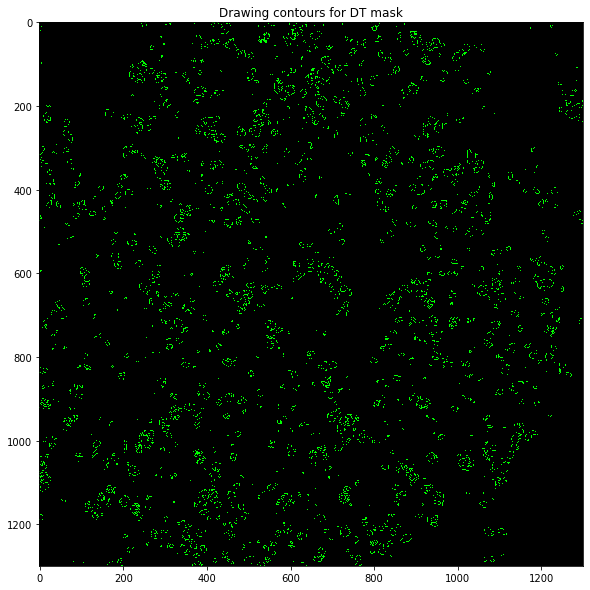

In [155]:
copy=dt_mask_single_typed
#drawing=cv2.drawContours(copy,contours,-1,(255,0,0),5)
#black_sheet=np.ndarray((len(copy[:,:,0]),len(copy[:,:,1]),len(copy[:,:,2])))
black_sheet=np.zeros((1300,1300,3))

cv2.drawContours(black_sheet,contours,-1,(0,1,0),1)

plt.figure(figsize=(10,10))
plt.title("Drawing contours for DT mask")
plt.imshow(black_sheet)
plt.show()

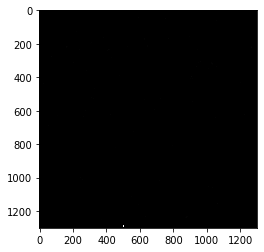

numpy.ndarray

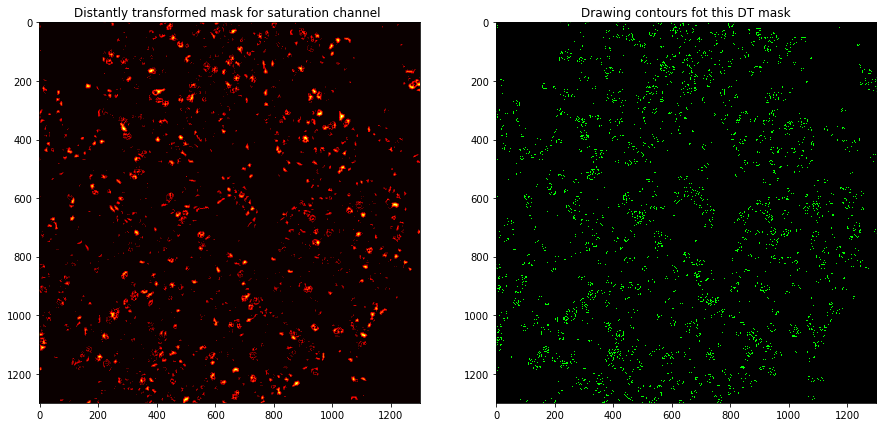

In [153]:
plt.figure(figsize=(15,15))
plt.subplot(1,2,1), 
plt.title("Distantly transformed mask for saturation channel"),
plt.imshow(dt_mask_single,cmap="hot")

plt.subplot(1,2,2),
plt.title("Drawing contours fot this DT mask"),
plt.imshow(black_sheet)

plt.show()

###  Trying to optimize image thresholding
###### Normalizing, blurring

## 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


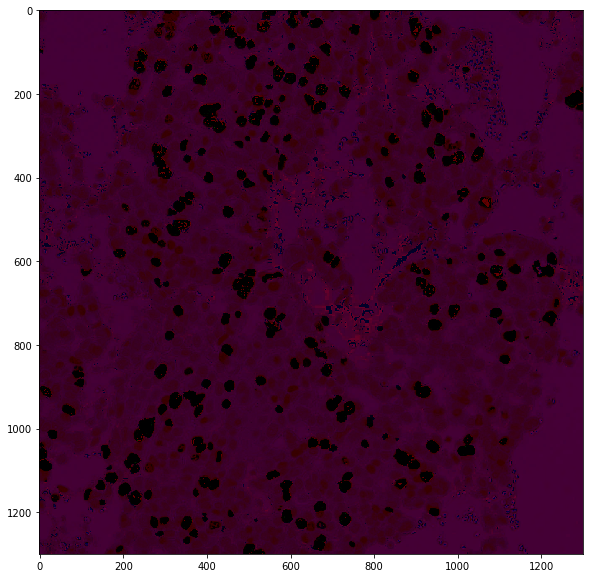

array([[-0.03094321, -0.03202514, -0.03224153, ..., -0.02553356,
        -0.02401886, -0.02293693],
       [-0.02598255, -0.02771472, -0.02987993, ..., -0.02511647,
        -0.02316777, -0.02273473],
       [-0.02095592, -0.02290029, -0.02549277, ..., -0.02506069,
        -0.02333237, -0.02290029],
       ...,
       [-0.03118444, -0.03118444, -0.03118444, ..., -0.03118444,
        -0.03118444, -0.03118444],
       [-0.03111731, -0.03111731, -0.03111731, ..., -0.03111731,
        -0.03111731, -0.03111731],
       [-0.03110713, -0.03110713, -0.03110713, ..., -0.03110713,
        -0.03110713, -0.03110713]])

In [12]:
import math
from sklearn import preprocessing

#How vitaly said
ideal_brown=np.array([15,155,150])
hsv_vector_norm=math.sqrt(180*180+255*255*2)
temp=(tissue_hsv-ideal_brown)/hsv_vector_norm


temp2=preprocessing.normalize(temp[:,:,1])
plt.figure(figsize=(10,10))
plt.imshow(temp,cmap="gray")
plt.show()
temp2
temp_s=temp[:,:,1]/255
temp2

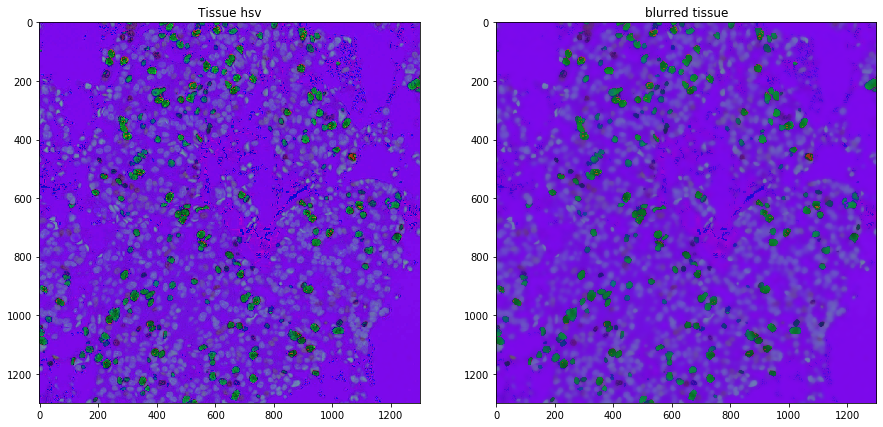

In [13]:
#Trying with brown interval
lower_brown=np.array([10, 100, 20])
upper_brown=np.array([20, 255, 200])


tissue_hsv_norm=tissue_hsv/hsv_vector_norm

lower_norm=lower_brown/hsv_vector_norm
upper_norm=upper_brown/hsv_vector_norm

#mask2=cv2.inRange(tissue_hsv_norm,lower_norm,upper_brown)

tissue_blurred=cv2.bilateralFilter(tissue_hsv,20,75,75)

plt.figure(figsize=(15,15))
plt.subplot(1,2,1), 
plt.title("Tissue hsv"),
plt.imshow(tissue_hsv)

plt.subplot(1,2,2),
plt.title("blurred tissue"),
plt.imshow(tissue_blurred)

NameError: name 'mask' is not defined

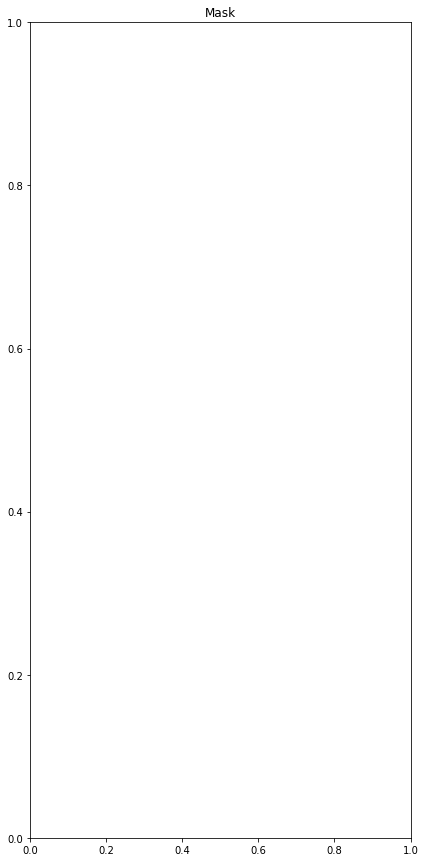

In [14]:
#Trying with BLURRED tissue
mask_blurred=cv2.inRange(tissue_blurred,lower_brown,np.array([180,255,255]))

plt.figure(figsize=(15,15))
plt.subplot(1,2,1), 
plt.title("Mask"),
plt.imshow(mask,cmap="gray")

plt.subplot(1,2,2),
plt.title("Blurred mask"),
plt.imshow(mask_blurred,cmap="gray")

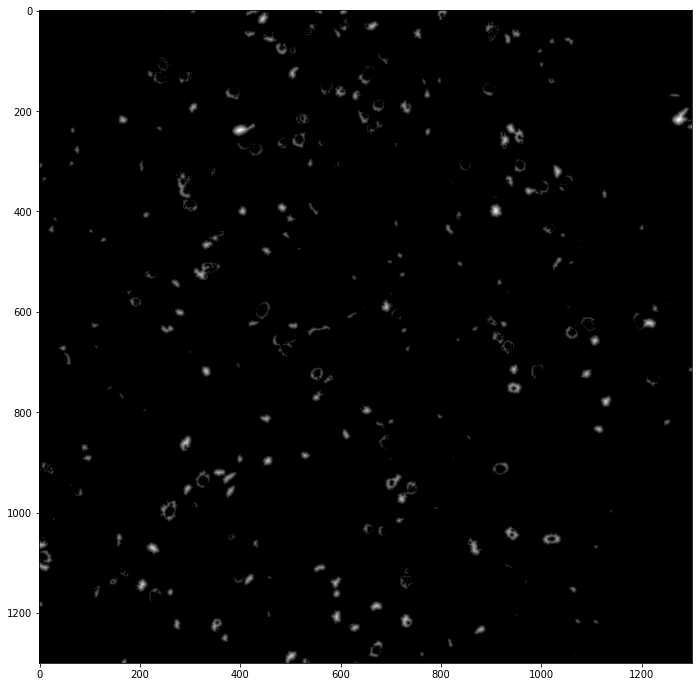

In [15]:
#Distance transform
mask_bl_dt=cv2.distanceTransform(mask_blurred,cv2.DIST_L2,5)

plt.figure(figsize=(12,12))
plt.imshow(mask_bl_dt,cmap="gray")
plt.show()

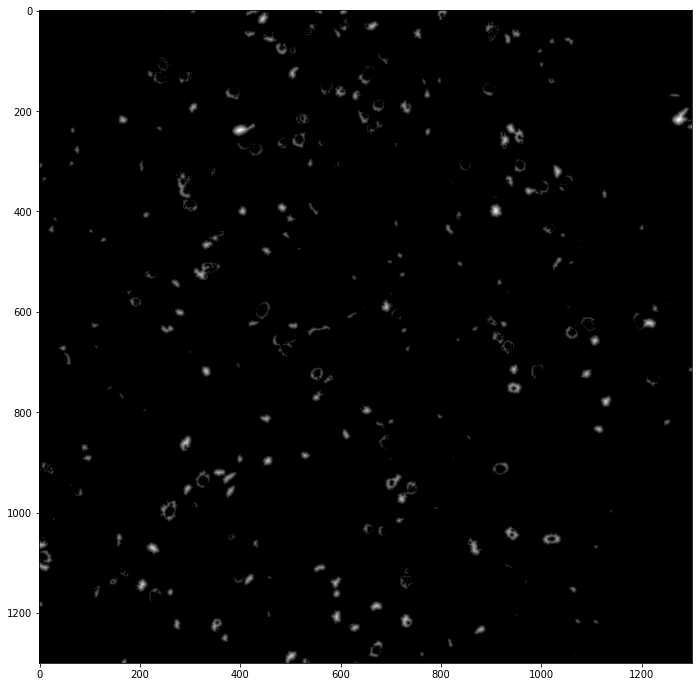

255.0

In [16]:
mask_bl_dt_scaled=mask_bl_dt/mask_bl_dt.max()*255


plt.figure(figsize=(12,12))
plt.imshow(mask_bl_dt_scaled,cmap="gray")
plt.show()
mask_bl_dt_scaled.max()

######  Main part, segmenting and counting cells

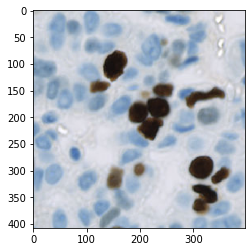

In [70]:
test_image=cv2.imread("F:\BSU_FAMCS\BMI\CourseProject\ImagePreprocessing\\small_region.png",cv2.IMREAD_COLOR)
test_image=cv2.cvtColor(test_image,cv2.COLOR_RGB2BGR)
#test_image=cv2.cvtColor(test_image,cv2.COLOR_BGR2HSV)

plt.imshow(test_image)
plt.show()

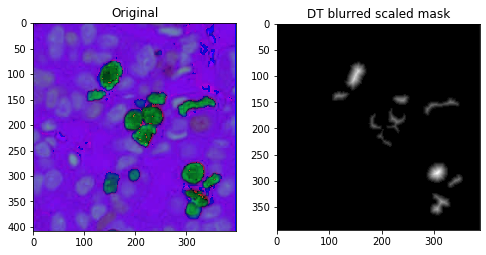

In [61]:
import cv2
from tqdm import tqdm
import numpy as np
from matplotlib import pyplot as plt

lower_brown=np.array([10, 100, 20])
upper_brown=np.array([20, 255, 200])

#test_image=cv2.imread("tissue_region.png")
#test_image=cv2.cvtColor(test_image,cv2.COLOR_BGR2HSV)

#Blurred mask
test_bl=cv2.bilateralFilter(test_image,20,75,75)
test_mask=cv2.inRange(test_bl,lower_brown,upper_brown)
#test_mask=cv2.imread("F:\BSU_FAMCS\BMI\CourseProject\ImagePreprocessing\\fake.png",cv2.IMREAD_GRAYSCALE)
#Distance transform
test_dt=cv2.distanceTransform(test_mask,cv2.DIST_L2,5)

test_dt_bl_scaled=test_dt/test_dt.max()*255

plt.figure(figsize=(8,8))
plt.subplot(1,2,1),plt.title("Original"),plt.imshow(test_image)
plt.subplot(1,2,2),plt.title("DT blurred scaled mask"),plt.imshow(test_dt_bl_scaled,cmap="hot")
plt.show()

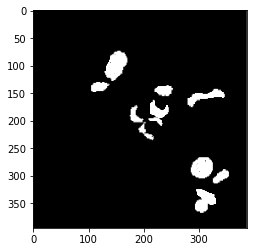

In [62]:
plt.imshow(test_mask,cmap="gray")
plt.show()

In [63]:
counter=0
centers=[]
small_value=10**-5

max_thresh=240
min_thresh=30
step=15

#dt_image=mask_bl_dt_scaled.copy()
dt_image=test_dt_bl_scaled


#it is important to do for making FindContours works
dt_image_c=cv2.convertScaleAbs(dt_image)


for threshold in tqdm(range(max_thresh,min_thresh,-step)):
    #first one is source image, second is contour retrieval mode, third is contour approximation method
    _, thresholded=cv2.threshold(dt_image_c,threshold,255,cv2.THRESH_BINARY)
    
    
     #preparing
    mask2=np.zeros((len(thresholded)+2,len(thresholded[0])+2),np.uint8)
    
    thresholded_copy=thresholded.copy()
    #Floodfilling existing cells
    for _,pair in enumerate(centers):
        #before fullfilling need to check whether this cell had already been filled
        if thresholded_copy[pair[1]][pair[0]]!=0:
            cv2.floodFill(thresholded_copy,mask2,(pair[0],pair[1]),0)
    
        
        
    #Finding contours for new cells    
    contours,hierarchy=cv2.findContours(thresholded_copy,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    
    #Searching for new cells centers
    new_centers=[]
    for index in range(len(contours)):
        moment=cv2.moments(contours[index])
        x=round(moment["m10"]/(moment["m00"]+small_value))
        y=round(moment["m01"]/(moment["m00"]+small_value))
        if x!=0 or y!=0:
            new_centers.append((x,y))
            counter=counter+1
        
    
#     plt.figure(figsize=(10,8))    
#     plt.subplot(1,3,1), plt.imshow(thresholded)
#     plt.subplot(1,3,2), plt.imshow(thresholded_copy)
#     plt.subplot(1,3,3), plt.imshow(mask2)
#     plt.show()
#     print(new_centers)
#     print(counter)
#     print(len(contours))
    
    centers.extend(new_centers)
    
    

100%|██████████| 14/14 [00:00<00:00, 495.75it/s]


In [64]:
counter

13

Without iterating: **598 cells**

With blurring and iterating from 240 to 30 with step=3: **316 cells**

In [65]:
centers_set=set(centers)
len(centers_set)

13

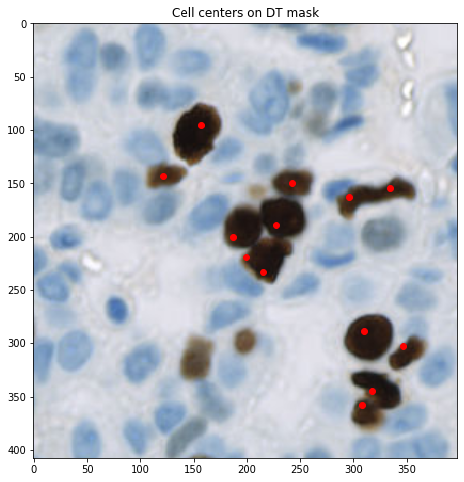

In [76]:
plt.figure(figsize=(8,8))
plt.title("Cell centers on DT mask")
plt.imshow(test_image,cmap="gray")
for _,value in enumerate(centers):
    plt.plot(value[0],value[1],"ro")
plt.show()    

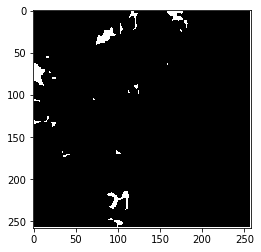

In [14]:
plt.imshow(mask2,cmap="gray")
#plt.plot(pair[0],pair[1],"bo")
plt.show()

In [278]:
len(contours)

5

In [279]:
len(centers)

28

In [297]:
centers

[(312, 296),
 (196, 189),
 (156, 94),
 (231, 181),
 (315, 363),
 (151, 317),
 (197, 297),
 (242, 149),
 (229, 208),
 (115, 144),
 (347, 312),
 (293, 169),
 (210, 160),
 (336, 157),
 (340, 318),
 (201, 221),
 (318, 161),
 (139, 119),
 (213, 234),
 (214, 223),
 (361, 303),
 (245, 61),
 (227, 225)]

In [283]:
centers_set

{(121, 143),
 (140, 118),
 (149, 124),
 (149, 322),
 (156, 91),
 (158, 118),
 (165, 106),
 (195, 197),
 (198, 299),
 (204, 222),
 (206, 211),
 (214, 223),
 (214, 233),
 (224, 179),
 (226, 225),
 (229, 208),
 (239, 191),
 (243, 150),
 (243, 178),
 (295, 169),
 (304, 335),
 (308, 301),
 (313, 365),
 (320, 291),
 (322, 351),
 (339, 155),
 (348, 311),
 (358, 302)}